### Biobjective otimization of the model's parameters for prediction of output voltage of the Buck converter CC-CC using as objectives the static curve information and the prediction error 

# Example: Buck converter

Example created by Gabriel Bueno Leandro

<div style="text-align: justify"> A buck converter is a type of DC/DC converter that decreases the voltage (while increasing the current) from its input (power supply) to its output (load). It is similar to a boost converter (elevator) and is a type of switched-mode power supply (SMPS) that typically contains at least two semiconductors (a diode and a transistor, although modern buck converters replace the diode with a second transistor used for synchronous rectification) and at least one energy storage element, a capacitor, inductor or both combined. </div>

In [14]:
# Importing the libraries and methods needed to run the notebook.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.multiobjective.multiobjective_parameter_estimation import IM
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_results
from sysidentpy.metrics import root_relative_squared_error

## Dynamic Behavior

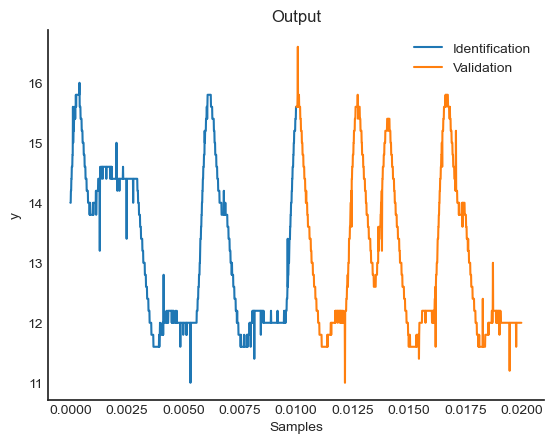

In [15]:
# Reading Buck's input and output data
data_train = pd.read_csv(r'examples/datasets/buck.txt' , sep=" ", header=None).to_numpy()
data_valid = pd.read_csv("examples/datasets/buck_val.txt" , sep =" ", header=None).to_numpy()

# Separating the identification data
data_samples_train = data_train[:, 2]
data_out_train = data_train[:, 6]
data_int_train = data_train[:, 4]

# Separating the validation data
data_samples_valid = data_valid[:, 2]
data_out_valid = data_valid[:, 6]
data_int_valid = data_valid[:, 4]

# Plotting the measured output (identification and validation data)
plt.figure(1)
plt.title('Output')
plt.plot(data_samples_train, data_out_train, label='Identification', linewidth=1.5)
plt.plot(data_samples_valid, data_out_valid , label='Validation', linewidth=1.5)
plt.xlabel('Samples')
plt.ylabel('y')
plt.legend()
plt.show()


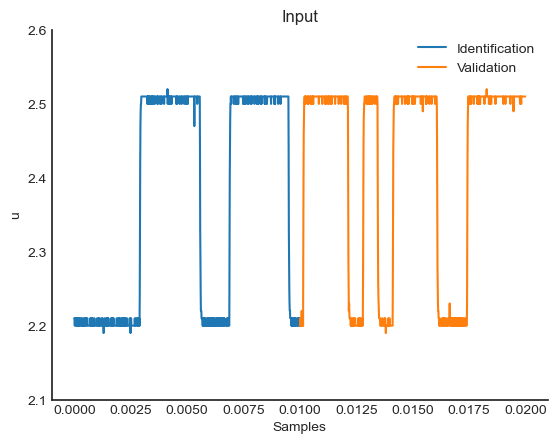

In [16]:
# Plotting the measured input(identification and validation data)
plt.figure(2)
plt.title('Input')
plt.plot(data_samples_train, data_int_train, label='Identification', linewidth=1.5)
plt.plot(data_samples_valid, data_int_valid, label='Validation', linewidth=1.5)
plt.ylim(2.1, 2.6)
plt.ylabel('u')
plt.xlabel('Samples')
plt.legend()
plt.show()

## Buck Converter Static Function

The duty cycle is defined by $D=\frac{T_{on}}{T}$ and its complement is $D'=\frac{T_{off}}{T}$ , where T is the operation cycle. The load voltage $V_o$ relates to the source voltage $V_d$ as $V_o = D\cdot V_d = (1 − D’)\cdot V_d$. This converter satisfies $D' = \frac{\bar{u}-1}{3}$ and therefore the static function of this system is known from theory to be:
$$
V_o = \frac{4V_d}{3} - \frac{V_d}{3}\cdot \bar{u}
$$

assuming $V_d = 24\:V $, the expression can be rewritten as follows:

$$
V_o = (4 - \bar{u})\cdot 8
$$

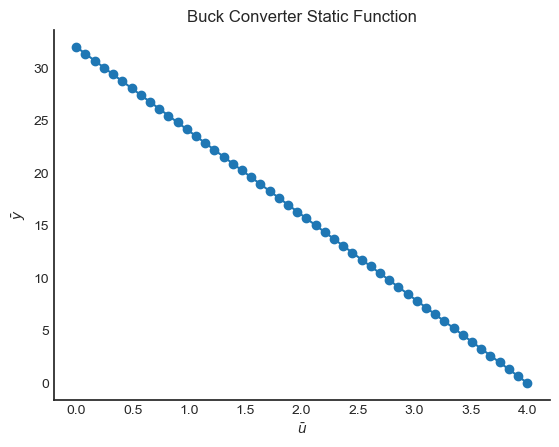

In [17]:
# Static data
Vd = 24
Uo = np.linspace(0, 4, 50)
Yo = (4-Uo)*Vd/3
Uo = Uo.reshape(-1, 1)
Yo = Yo.reshape(-1, 1)
plt.figure(3)
plt.title('Buck Converter Static Function')
plt.xlabel('$\\bar{u}$')
plt.ylabel('$\\bar{y}$')
plt.plot(Uo, Yo, linewidth=1.5, linestyle='-', marker='o')
plt.show()

In [18]:
# Informing test and validation data
x_train = data_int_train.reshape(-1, 1)
y_train = data_out_train.reshape(-1, 1)
x_valid = data_int_valid.reshape(-1, 1)
y_valid = data_out_valid.reshape(-1, 1)

basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=True,
    n_info_values=8,
    extended_least_squares=False,
    ylag=2, xlag=2,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)

model.fit(X=x_train, y=y_train)

c:\Users\55359\OneDrive\Área de Trabalho\Clone_git\sysidentpy\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


In [19]:
# Calling the class referring to the calculation of the parameters via the multiobjective technique
mult = IM(sf=True, sg=False, model_type='NARMAX',
        final_model = model.final_model, 
        norm=False)

In [20]:
# Method to calculate the parameters
              #[0.0068874]])
J, w, E, Theta, HR, QR, position = mult.affine_information_least_squares(y_train=y_train[2:],
                                                                         y_static=Yo,
                                                                         x_static=Uo, psi=model.psi)
result = {'w1': w[0,:],
          'w2': w[1,:],
          'J_ls': J[0,:],
          'J_sg': J[1,:],
          '||J||:': E}
pd.DataFrame(result)


,w1,w2,J_ls,J_sg,||J||:
0,0.006842,0.993158,16.454437,0.000003,16.454437
1,0.007573,0.992427,16.454350,0.000004,16.454350
2,0.008382,0.991618,16.454260,0.000005,16.454260
3,0.009277,0.990723,16.454168,0.000006,16.454168
4,0.006842,0.993158,16.454437,0.000003,16.454437
...,...,...,...,...,...
2290,0.659632,0.340368,16.447917,0.003325,16.447918
2291,0.730119,0.269881,16.447299,0.004742,16.447300
2292,0.808139,0.191861,16.446627,0.007006,16.446628
2293,0.894495,0.105505,16.445970,0.010844,16.445973


In [21]:
# Writing the results
model.theta = Theta[position, :].reshape(-1,1)
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=3, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-1),-3.5264E-01,9.999E-01
1,y(k-2),5.2682E-01,2.042E-05
2,x1(k-1)y(k-1),1.3784E-01,1.108E-06
3,1,8.8958E+00,4.688E-06
4,y(k-1)^2,2.8232E-01,3.922E-07
5,x1(k-1),-2.2365E+00,8.389E-07
6,y(k-2)y(k-1),-5.2112E-01,5.690E-07
7,y(k-2)^2,2.5592E-01,3.827E-06


dynamic data in graphical form:

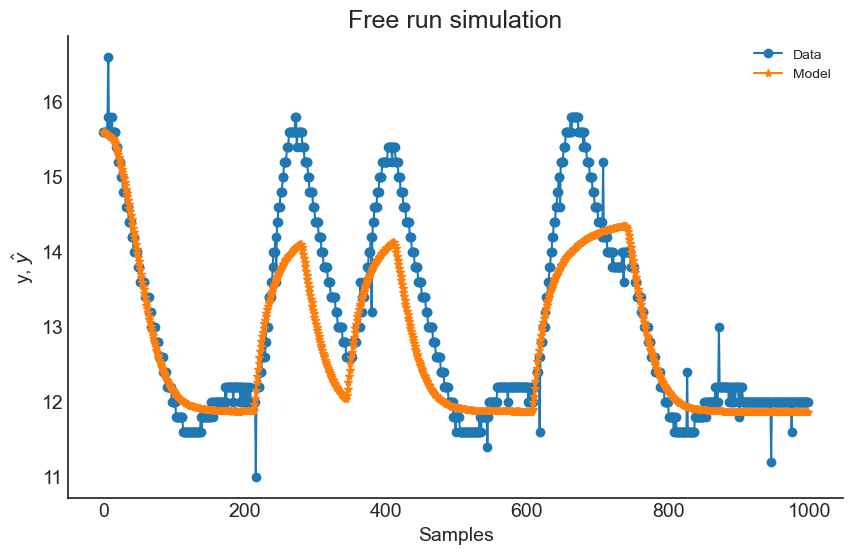

In [22]:
plot_results(y=y_valid, yhat=yhat, n=1000)

the static function graphically:

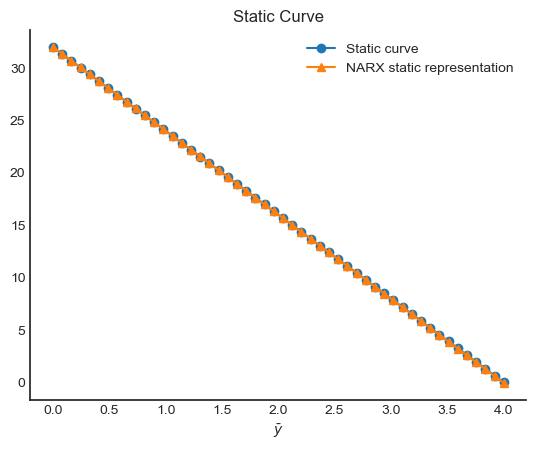

In [23]:
plt.figure(4)
plt.title('Static Curve')
plt.plot(Uo, Yo, linewidth=1.5, label='Static curve',  linestyle='-', marker='o')
plt.plot(Uo, QR.dot(model.theta), linewidth=1.5, label='NARX ​​static representation', linestyle='-', marker='^')
plt.xlabel('$\\bar{u}$')
plt.xlabel('$\\bar{y}$')
plt.legend()
plt.show()